##### The pipeline for this project 'Finding Advanced Lane Lines' processes images and videos in the following steps:

> 1. Apply distortion correction using a calculated camera calibration matrix and distortion coefficients.
> 2. Apply color and gradient thresholds to create binary image which isolates the pixels representing lane lines.
> 3. Apply a perspective transformation to warp the image to a birds eye view perspective of the lane lines.
> 4. Identify the lane line pixels through different Searching methods and fit polynomials to the lane boundaries.
S Determine curvature of the lane and vehicle position with respect to lane center.
Step 6: Warp the detected lane boundaries back onto the original image by applying Inverse perspective transform.
Step 7: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
Step 8: Test and apply the pipeline on Images and Videos.

In [18]:
# Importing Libraries
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

%matplotlib inline

### Check a Sample for Calibration

Let's check an image to be used for calibration, and print its size.

(720, 1280, 3)


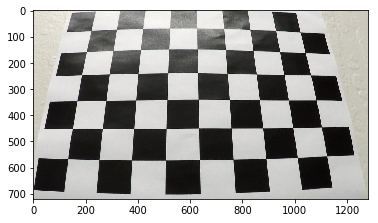

In [19]:
img = mpimg.imread('camera_cal/calibration3.jpg')
print(img.shape)
plt.imshow(img)

### Step 1- Camera Calibration
As already instructed and also observed above, there are 9 inner row corners and 6 inner colum corners. 
Library 'glob' is used to iterate over all the camera_cal images.

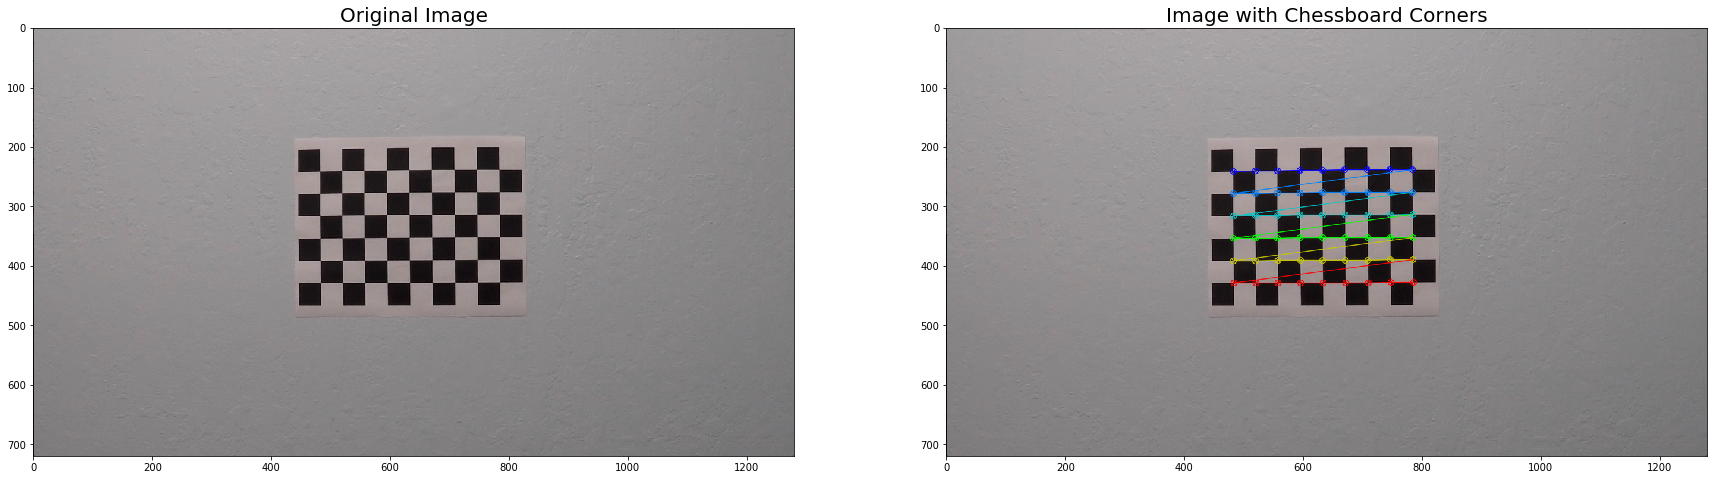

In [20]:
# Step 1 - Calibrating the Camera

# define number of inner corners in row and column
nx = 9
ny = 6

objpoints = [] # object points
imgpoints = [] # image points

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

fnames = glob.glob("camera_cal/calibration*.jpg")

f, (axs1, axs2) = plt.subplots(1,2,figsize=(30,30))

for index,fname in enumerate(fnames):
    originalImage= cv2.imread(fname)
    grayImage= cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY) 
    # Converting to Grayscale before finding Chessboard Corners

    if(index == 3 ):
        # Plot the original Image
        axs1.set_title('Original Image', fontsize=20)
        axs1.imshow(originalImage)

    # Find Chessboard corners
    ret, corners = cv2.findChessboardCorners(grayImage, (nx,ny), None)
    if(ret == True):
        objpoints.append(objp)
        imgpoints.append(corners)

        # Drawing Chessboard Corners
        cv2.drawChessboardCorners(originalImage, (nx,ny), corners, ret)
        # Plot the image with Chessboard corners
        if(index == 3):
            axs2.set_title('Image with Chessboard Corners', fontsize=20)
            axs2.imshow(originalImage)

# From this, we get the Object Points (3D points in Real World Space) and Image Points (2D points in Image Space).

### Step 2 - Calculating Undistortion Parameters

Text(0.5,1,'Undistorted Images')

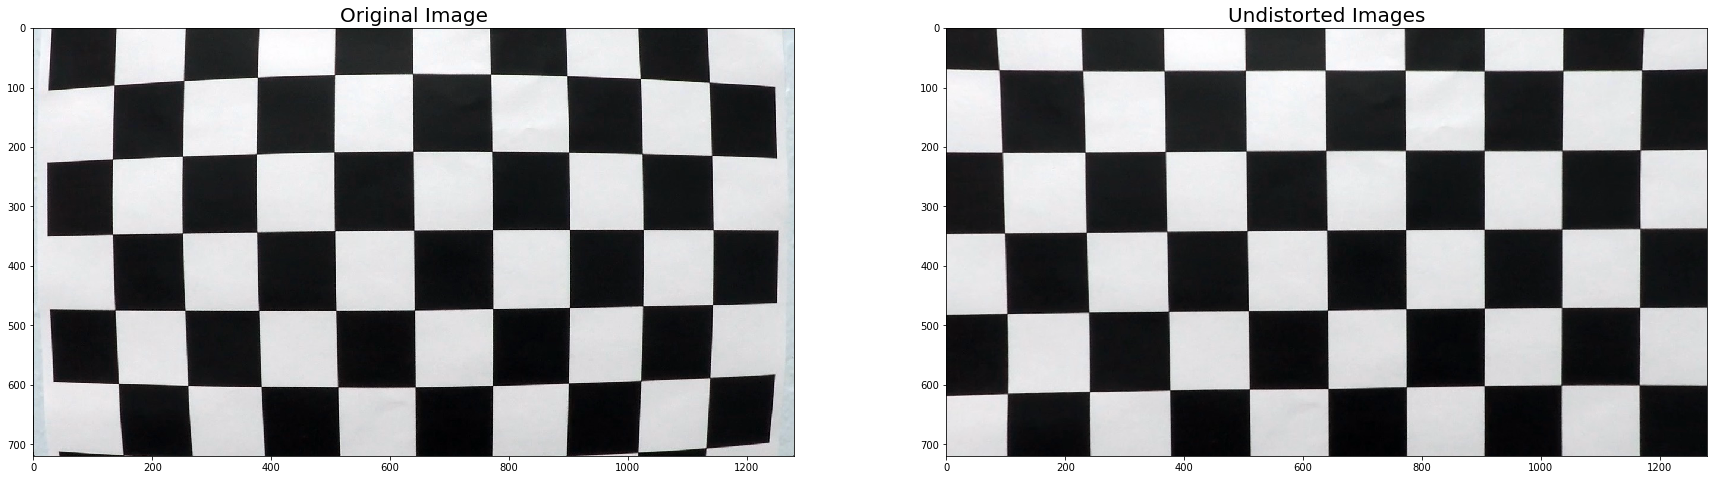

In [21]:
# Step 2- Calculating Undistortion Parameters

img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# mtx = Camera Matrix (for converting 3D object to 2D image)
# dist = Distortion Coefficients (k1, k2, p1, p2, k3) to undistort a given Camera image.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

# Destination Image (i.e. Undistorted)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (axs1, axs2) = plt.subplots(1,2,figsize=(30,30))


axs1.imshow(img)
axs1.set_title("Original Image", fontsize=20)
axs2.imshow(dst)
axs2.set_title("Undistorted Images", fontsize=20)

# From this, we get the Distortion Coefficient and Camera Matrix.

### Step 3 - Undistorting the test images

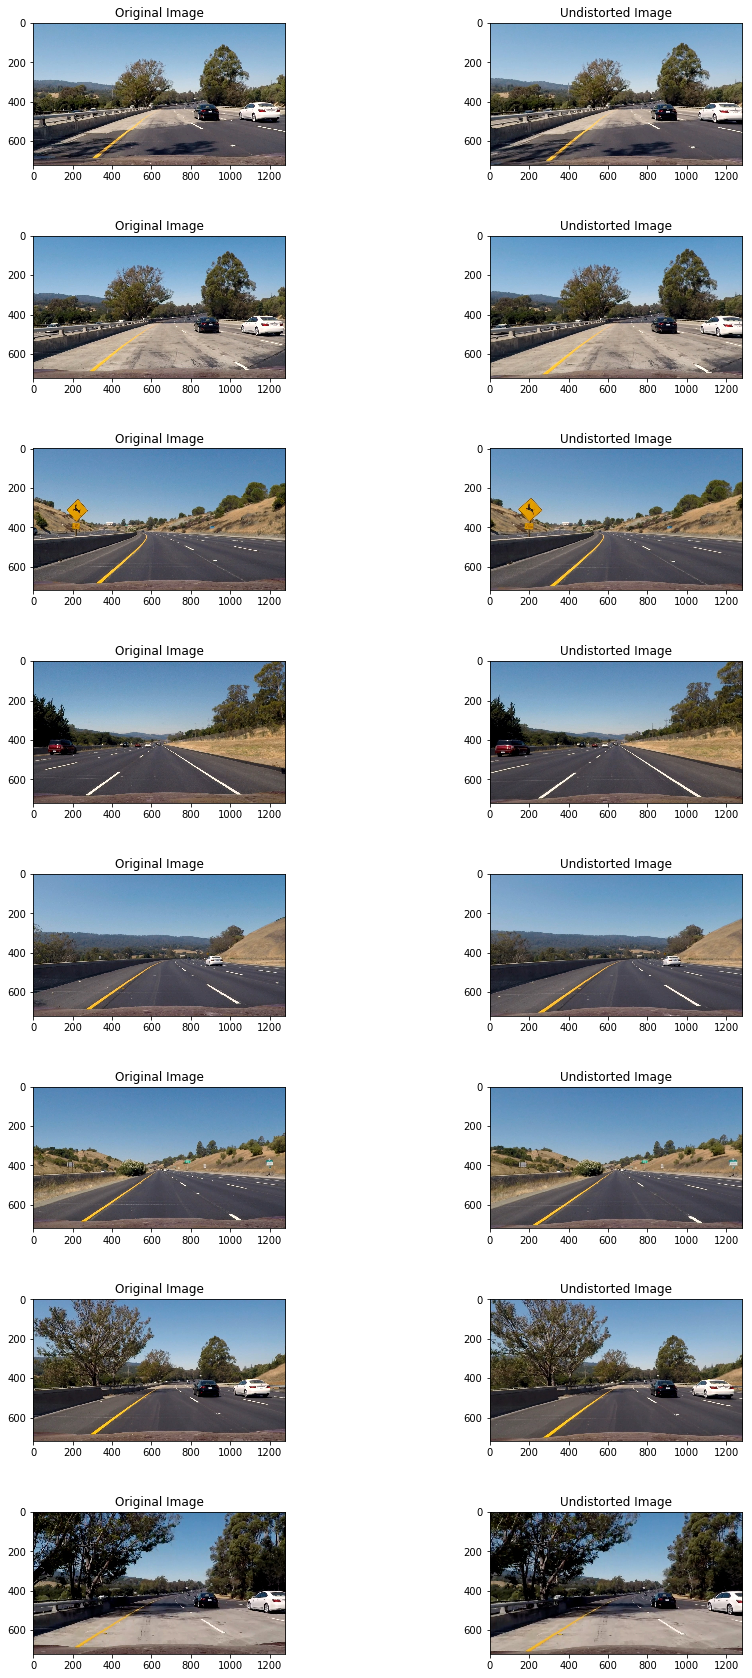

In [22]:
# Step 3- Defining a function to undistort Images using parameters derived from previous step

def undistortImage(image, mtx, dist):
    return cv2.undistort(image, mtx, dist, None, mtx)


# Undistorting Test Images
f, axes= plt.subplots(8,2,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

images = glob.glob('test_images/*.jpg') # Reading Images from test_images folder
originalImages = []

for index, image in enumerate(images):
    originalImage = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    originalImages.append(originalImage)
    axes[index,0].imshow(originalImage)
    axes[index,0].set_title("Original Image")
    undistortedImage = undistortImage(originalImage, mtx, dist) # Undistorting the Image 
    axes[index,1].set_title("Undistorted Image")
    axes[index,1].imshow(undistortedImage)

### Step 4 - Gradients and color transforms

##### Two Gradients are taken:
1. Gradient (Sobel) is taken along x-axis, as the lanes are nearly vertical.
2. Direction Gradient is taken, thresholds between 0.523 (pi/6) and 1.57 (pi/2).


##### Color thresholds applied are:
1. R & G channel thresholds, so that white lanes are detected well.
2. L channel threshold, so that we don't consider edges generated due to shadows.
3. S channel threshold, as it does a great job of finding yellow lanes.

In [23]:
def get_thresholded_image(img):
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    height, width = gray.shape
    
    # Apply threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(gray, 'x', thresh=(10, 200))
    
    # Apply gradient direction threshold so that only edges closer to vertical are detected
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    # Combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow & white lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    
    # Color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # Threshold L channel to avoid pixels which have shadows and as a result are darker
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # Combine all the thresholds
    # Relevant pixels should either be a yellowish or whiteish
    # And these should also have a gradient, as per the thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    # Apply the region of interest (ROI) mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded 
    
def abs_sobel_thresh(gray, orient='x', thresh=(0,255)):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    scaled_sobel = np.uint8(255*abs_sobel/max_value)
    binary_sobel = np.zeros_like(scaled_sobel)
    binary_sobel[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_sobel

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    directionGrad = np.arctan2(abs_sobel_y,abs_sobel_x)
    directionGrad = np.absolute(directionGrad)
    # 5) Create a binary mask where direction thresholds are met
    binary_direction = np.zeros_like(directionGrad)
    binary_direction[(directionGrad >= thresh[0]) & (directionGrad <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_direction


##### Some Examples for the above

Text(0.5,1,'Thresholded Image2')

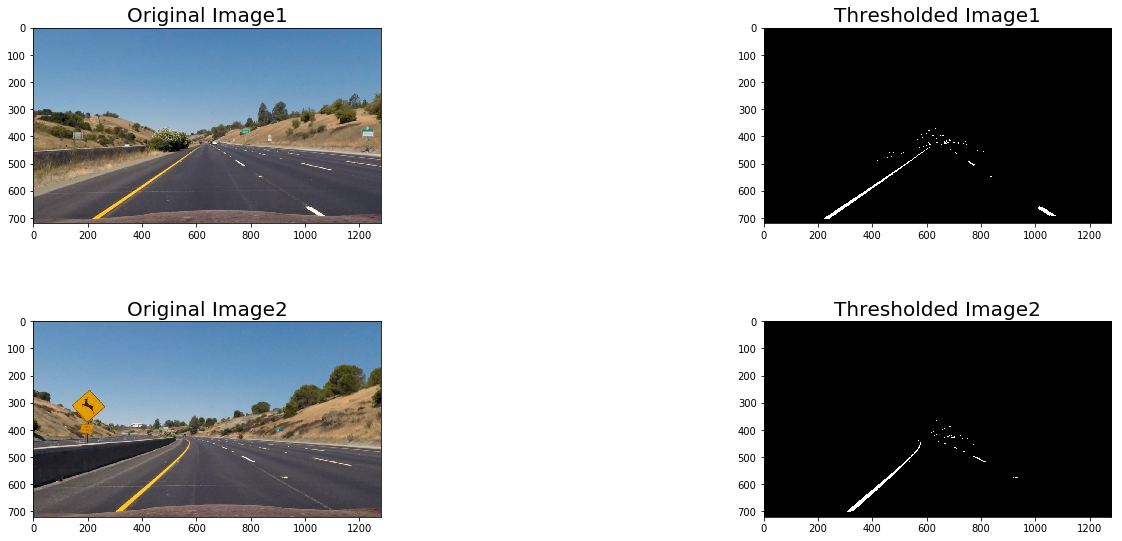

In [24]:
img1 = mpimg.imread('test_images/straight_lines1.jpg')
img2 = mpimg.imread('test_images/test2.jpg')

thresholded1 = get_thresholded_image(img1)
thresholded2 = get_thresholded_image(img2)

img1 = cv2.undistort(img1, mtx, dist, None, mtx)
cv2.imwrite('thresholded_straight_lines1.jpg',thresholded1)
img2 = cv2.undistort(img2, mtx, dist, None, mtx)
cv2.imwrite('thresholded_test2.jpg',thresholded2)

# Plot images side by side
f, axes = plt.subplots(2, 2, figsize=(24, 9))
f.subplots_adjust(hspace=0.5)

axes[0,0].imshow(img1)
axes[0,0].set_title('Original Image1', fontsize=20)
axes[0,1].imshow(thresholded1, cmap='gray')
axes[0,1].set_title('Thresholded Image1', fontsize=20)
axes[1,0].imshow(img2)
axes[1,0].set_title('Original Image2', fontsize=20)
axes[1,1].imshow(thresholded2, cmap='gray')
axes[1,1].set_title('Thresholded Image2', fontsize=20)

### Step 5 - Perspective Transform
    Get a Warped (bird's eye view) undistorted image.
    
1. Examining the above sample images, Extract the vertices (of RoI) to perform a perspective transform. The polygon with these vertices is drawn on the image for visualization. Destination points are chosen such that straight/curved lanes appear more or less parallel in the transformed image.

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 570, 470      | 320, 1        | 
| 220, 720      | 320, 720      |
| 1110, 720     | 920, 720      |
| 722, 470      | 920, 1        |

2. The transform and its inverse are computed, for later use. Just, transform the binary image to show the bird's eye view.

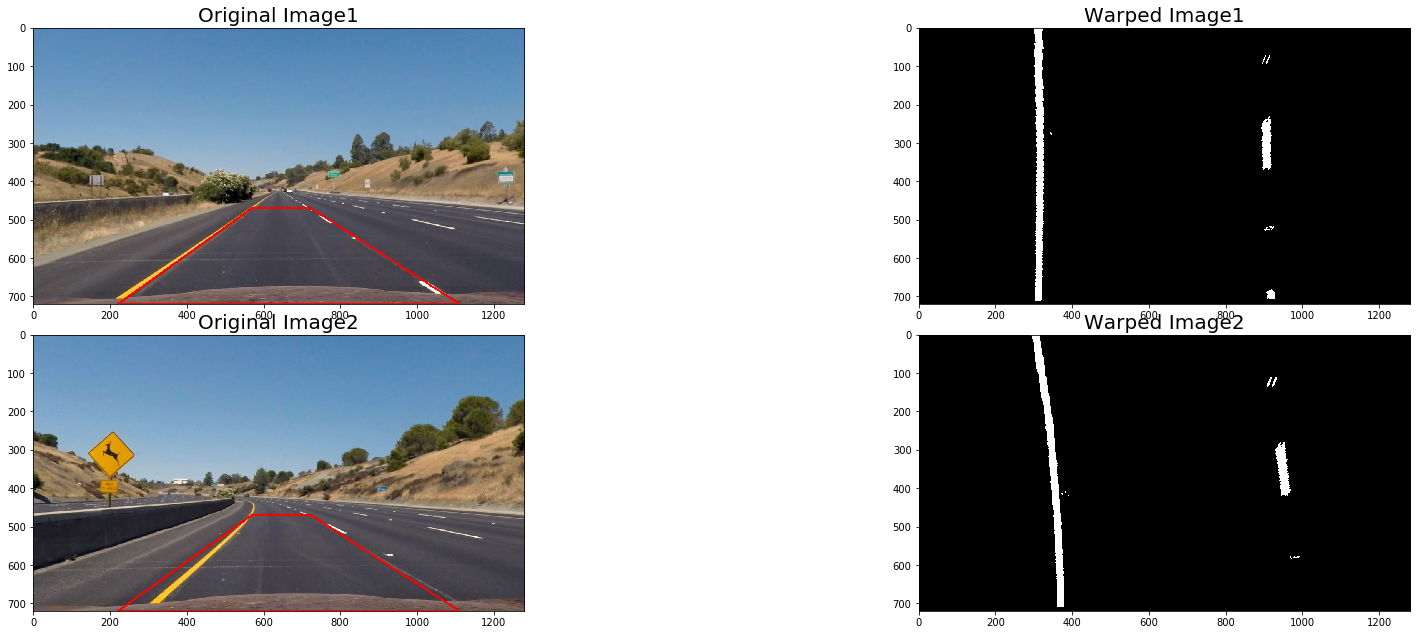

In [25]:
# Vertices extracted manually for performing a perspective transform
bottom_left = [220, 720]
bottom_right = [1110, 720]
top_left = [570, 470]
top_right = [722, 470]

source = np.float32([bottom_left,bottom_right,top_right,top_left])

pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
copy1 = img1.copy()
cv2.polylines(copy1,[pts],True,(255,0,0), thickness=3)
copy2 = img2.copy()
cv2.polylines(copy2,[pts],True,(255,0,0), thickness=3)

# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
bottom_left = [320,720]
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])
M = cv2.getPerspectiveTransform(source, dst) # Imp.
M_inv = cv2.getPerspectiveTransform(dst, source) # Imp.
img_size = (img1.shape[1], img1.shape[0])

warped1 = cv2.warpPerspective(thresholded1, M, img_size , flags=cv2.INTER_LINEAR)
warped2 = cv2.warpPerspective(thresholded2, M, img_size , flags=cv2.INTER_LINEAR)
    
f, axes = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
axes[0,0].imshow(copy1)
axes[0,0].set_title('Original Image1', fontsize=20)
axes[0,1].imshow(warped1, cmap='gray')
axes[0,1].set_title('Warped Image1', fontsize=20)
axes[1,0].imshow(copy2)
axes[1,0].set_title('Original Image2', fontsize=20)
axes[1,1].imshow(warped2, cmap='gray')
axes[1,1].set_title('Warped Image2', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step 6 - Identifying the lane pixels

##### (A) Histogram
Histogram's prominent peaks will tell us about the likely positions of left and right lanes in the image.

##### (B) Sliding Window Search
1. Perform the Sliding window search, starting with the likely base positions of left and right lanes, calculated from the histogram. I have used 10 windows of width 100 pixels each.
2. 'x' & 'y' coordinates of the non-zeros pixels (in binary image) are found that are relevant to the corresponding lanes, a second degree polynomial is fit to these coordinates and the lane lines are drawn (for visualisation).

307 908


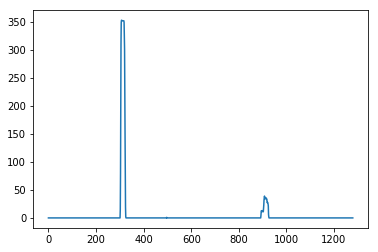

In [26]:
histogram = np.sum(warped1[np.int(warped1.shape[0]/2):,:], axis=0)

# Prominent peaks in the first half of bottom half image indicate the likely position of the left lane
half_width = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:half_width])

# Prominent peaks in the second half of bottom half image indicate the likely position of the right lane
rightx_base = np.argmax(histogram[half_width:]) + half_width

print(leftx_base, rightx_base)
plt.plot(histogram)

(720, 0)

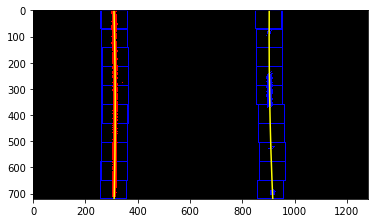

In [27]:
out_img = np.dstack((warped1, warped1, warped1))*255

non_zeros = warped1.nonzero()
non_zeros_y = non_zeros[0]
non_zeros_x = non_zeros[1]

num_windows = 10
num_rows = warped1.shape[0]
window_height = np.int(num_rows/num_windows)
window_half_width = 50

min_pixels = 100

left_coordinates = []
right_coordinates = []

for window in range(num_windows):
    y_max = num_rows - window*window_height
    y_min = num_rows - (window+1)* window_height
    
    left_x_min = leftx_base - window_half_width
    left_x_max = leftx_base + window_half_width
    
    cv2.rectangle(out_img, (left_x_min, y_min), (left_x_max, y_max), [0,0,255],3)
    
    good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
    left_coordinates.append(good_left_window_coordinates)
    
    if len(good_left_window_coordinates) > min_pixels:
        leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))
    
    right_x_min = rightx_base - window_half_width
    right_x_max = rightx_base + window_half_width
    
    cv2.rectangle(out_img, (right_x_min, y_min), (right_x_max, y_max), [0,0,255],3)
    
    good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
    right_coordinates.append(good_right_window_coordinates)
        
    if len(good_right_window_coordinates) > min_pixels:
        rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))
        
left_coordinates = np.concatenate(left_coordinates)
right_coordinates = np.concatenate(right_coordinates)

out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]

left_x = non_zeros_x[left_coordinates]
left_y = non_zeros_y[left_coordinates]

polyfit_left = np.polyfit(left_y, left_x, 2)

right_x = non_zeros_x[right_coordinates]
right_y = non_zeros_y[right_coordinates]

polyfit_right = np.polyfit(right_y, right_x, 2)

y_points = np.linspace(0, num_rows-1, num_rows)

left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

plt.imshow(out_img)
plt.plot(left_x_predictions, y_points, color='yellow')
plt.plot(right_x_predictions, y_points, color='yellow')
plt.xlim(0, warped1.shape[1])
plt.ylim(warped1.shape[0],0)

### Step 7 - Searching from Prior, i.e. Previously detected lane lines.
Since subsequent frames in a video are likely to have the lane lines in roughly similar or matching positions, Search around a margin of 50 pixels of the previously detected lane lines.

(720, 0)

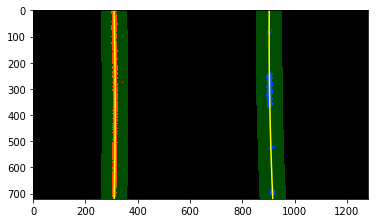

In [28]:
warped = cv2.warpPerspective(thresholded1, M, img_size , flags=cv2.INTER_LINEAR)

margin = 50
out_img = np.dstack((warped, warped, warped))*255

left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]

out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]

left_x = non_zeros_x[left_coordinates]
left_y = non_zeros_y[left_coordinates]

polyfit_left = np.polyfit(left_y, left_x, 2)

right_x = non_zeros_x[right_coordinates]
right_y = non_zeros_y[right_coordinates]

polyfit_right = np.polyfit(right_y, right_x, 2)

y_points = np.linspace(0, num_rows-1, num_rows)

left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

window_img = np.zeros_like(out_img)

left_line_window_1 = np.array(np.transpose(np.vstack([left_x_predictions - margin, y_points])))

left_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([left_x_predictions + margin, y_points]))))

left_line_points = np.vstack((left_line_window_1, left_line_window_2))

cv2.fillPoly(window_img, np.int_([left_line_points]), [0,255, 0])

right_line_window_1 = np.array(np.transpose(np.vstack([right_x_predictions - margin, y_points])))

right_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions + margin, y_points]))))

right_line_points = np.vstack((right_line_window_1, right_line_window_2))

cv2.fillPoly(window_img, np.int_([right_line_points]), [0,255, 0])

result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_x_predictions, y_points, color='yellow')
plt.plot(right_x_predictions, y_points, color='yellow')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0],0)

### Step 8 - Calculate  the Radius of Curvature and Car's offset from Lane Center.
1. The radius of curvature is calculated according to the formula and method described in the classroom material. Since we perform the polynomial fit in pixels and whereas the curvature has to be calculated in real world meters, we have to use a pixel to meter transformation and recalculate the fit again.

2. The mean of the lane pixels closest to the car gives us the center of the lane. The center of the image gives us the position of the car. The difference between the 2 is the offset from the center.

In [29]:
# Calculate the Radius of Curvature for both lane and then take an average.
def measure_radius_of_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

left_curve_rad = measure_radius_of_curvature(left_x_predictions)
right_curve_rad = measure_radius_of_curvature(right_x_predictions)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
print(curvature_string)

# Calculate Vehicle's offset distance from the lane's center
lane_center = (right_x_predictions[719] + left_x_predictions[719])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)

Radius of curvature: 4709.52 m
Center offset: 0.14 m


### Step 9 - Take 'Inverse Transform'

Now, unwarp the Lanes from bird-eye view to Front Camera view again.
For this:
1. Paint the lane area
2. Perform an inverse perspective transform
3. Combine the unwarped lanes image with the original image.

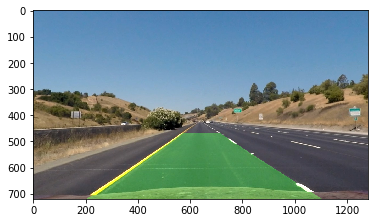

In [30]:
out_img = np.dstack((warped, warped, warped))*255

y_points = np.linspace(0, num_rows-1, num_rows)

left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))

right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))

line_points = np.vstack((left_line_window, right_line_window))

cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])

unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)

result = cv2.addWeighted(img1, 1, unwarped, 0.3, 0)

plt.imshow(result)

#### Finding Bad Frames
In videos, there will be some frames where no lanes are detected or the lanes might not make sense. 

We determine the bad frames if any of the following conditions are met:
1. No pixels were detected using the sliding window search or search around the previously detected line.
2. The average gap between the lanes is less than 0.7 times or greater than 1.3 times the globally maintained moving average of the lane gap.

#### Averaging lanes
The lane for each frame is a simple average of 12 previously computed lanes. This is done in the get_averaged_line method below.

#### What to do : If a bad frame is detected?
1. Perform a sliding window search again (this is done in the brute_search method below)
2. If this still results in a bad frame then we fall back to the previous well detected frame.

#### Final Pipeline
Combine all the code described in the code block above, plus the averaging and fallback techniques described in this block. The final code is in the pipeline_final method below.

In [31]:
# Some global variables
polyfit_left=None
polyfit_right=None

past_good_left_lines = []
past_good_right_lines = []

running_mean_difference_between_lines = 0

def get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows):
    """
        Given ncoordinates of non-zeros pixels and coordinates of non-zeros pixels within the sliding windows,
        this function generates a prediction for the lane line.
    """
    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]
    
    # If no pixels were found return None
    if(left_y.size == 0 or left_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_left = np.polyfit(left_y, left_x, 2)

    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]
    
    # If no pixels were found return None
    if(right_y.size == 0 or right_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_right = np.polyfit(right_y, right_x, 2)

    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    # Generate the lane lines from the polynomial fit
    left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
    right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    
    return left_x_predictions, right_x_predictions

def brute_search(warped):
    """
        This function searches for lane lines from scratch.
        Thresholding & performing a sliding window search.
    """
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    
    histogram = np.sum(warped[np.int(warped.shape[0]/2):,:], axis=0)

    half_width = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:half_width])
    rightx_base = np.argmax(histogram[half_width:]) + half_width

    num_windows = 10
    window_height = np.int(num_rows/num_windows)
    window_half_width = 50

    min_pixels = 100

    left_coordinates = []
    right_coordinates = []

    for window in range(num_windows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height

        left_x_min = leftx_base - window_half_width
        left_x_max = leftx_base + window_half_width

        good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)

        if len(good_left_window_coordinates) > min_pixels:
            leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))

        right_x_min = rightx_base - window_half_width
        right_x_max = rightx_base + window_half_width

        good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)

        if len(good_right_window_coordinates) > min_pixels:
            rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    
    left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    return left_x_predictions, right_x_predictions

def get_averaged_line(previous_lines, new_line):
    """
        This function computes an averaged lane line by averaging over previous good frames.
    """
    
    # Number of frames to average over
    num_frames = 12
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line
        
        
def get_mean_distance_between_lines(left_line, right_line, running_average):
    """
        Returns running weighted average of simple difference between left and right lines
    """
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average
    

def pipeline_final(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    img_shape = img.shape
    img_size = (img_shape[1], img_shape[0])
    
    # get thresholded image
    thresholded = get_thresholded_image(img)
    
    # perform a perspective transform
    warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    
    out_img = np.dstack((warped, warped, warped))*255
    
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then perform a brute force search
        brute = True
        left_x_predictions, right_x_predictions = brute_search(warped)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        brute = False
        margin = 100
        left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
        left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

        right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
        right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]
        
        left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    
    if (left_x_predictions is None or right_x_predictions is None):
        if not brute:
            left_x_predictions, right_x_predictions = brute_search(warped)
            
    bad_lines = False
            
    if (left_x_predictions is None or right_x_predictions is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
            if not brute:
                left_x_predictions, right_x_predictions = brute_search(warped)
                if (left_x_predictions is None or right_x_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return img
        else:
            left_x_predictions = past_good_left_lines[-1]
            right_x_predictions = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_x_predictions = get_averaged_line(past_good_left_lines, left_x_predictions)
        past_good_right_lines, right_x_predictions = get_averaged_line(past_good_right_lines, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
    
    # compute the radius of curvature
    left_curve_rad = measure_radius_of_curvature(left_x_predictions)
    right_curve_rad = measure_radius_of_curvature(right_x_predictions)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (right_x_predictions[num_rows-1] + left_x_predictions[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

### Test on 1 Image
Apply the pipeline to one test image. The original image and the processed image are shown side by side.

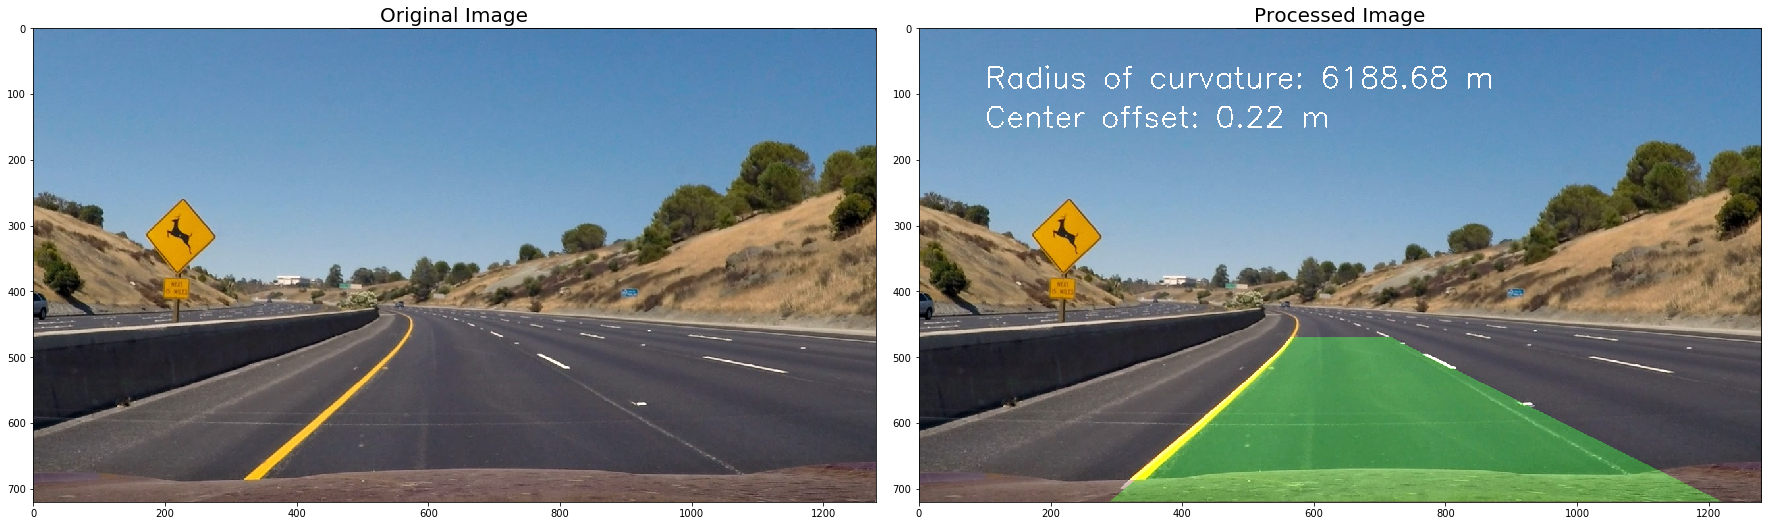

In [48]:
img = mpimg.imread('test_images/test2.jpg')

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

# Apply pipeline
processed = pipeline_final(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Running the pipeline on all Test Image

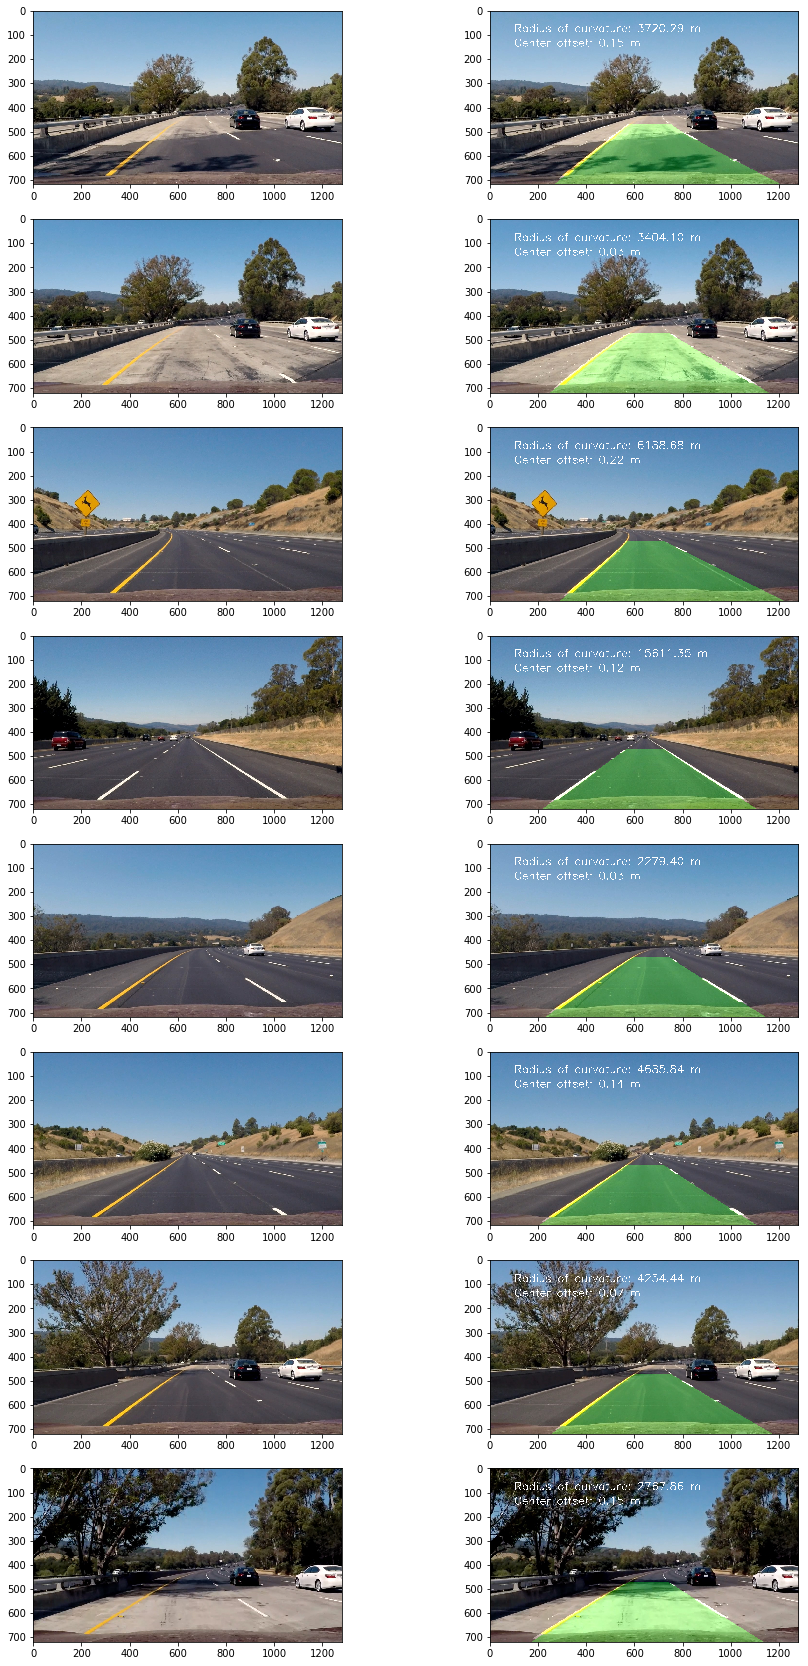

In [49]:
# Testing on all test images
f, axes= plt.subplots(8,2,figsize=(15,30))

fnames = glob.glob('test_images/*.jpg') # Reading Images from test_images folder

for index, fname in enumerate(fnames):
    originalImage = mpimg.imread(fname)
    finalImage = pipeline_final(originalImage)
    cv2.imwrite('output_images/'+str(index)+'.jpg', cv2.cvtColor(finalImage,cv2.COLOR_BGR2RGB))
    axes[index,0].imshow(originalImage)
    axes[index,1].imshow(finalImage)

### Running pipeline on Videos
Import 'moviepy' to apply the above pipeline to given videos.

In [32]:
from moviepy.editor import VideoFileClip

In [51]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:45<00:00,  3.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 27s, sys: 1.55 s, total: 4min 29s
Wall time: 6min 48s


### Testing pipeline on the Challenge Video
Apply the pipeline on the challenge video. The challenge video has:
1. Lanes lines or the highway along the lane lines change color
2. Brightness of the lanes varies throughout the video.
3. Shadows cast by the lane divider.
4. Challenge posed when the Car passing underneath a bridge or tunnel.

In [17]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0


output = 'challenge_video_output1.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video_output1.mp4
[MoviePy] Writing video challenge_video_output1.mp4


100%|██████████| 485/485 [02:43<00:00,  3.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output1.mp4 

CPU times: user 1min 39s, sys: 15.4 s, total: 1min 54s
Wall time: 2min 46s


##### The pipeline still works well on the challenge video.

## Discussion

### Issues and Challenges

##### Gradient & Color Thresholding
1. A lot of my time are spent on experimenting with gradient and color channnel thresholding.
2. The lanes lines in the challenge and harder challenge videos were extremely difficult to detect. They were either too bright or too dull. This prompted me to have R & G channel thresholding and L channel thresholding, along with the suggested S channel in classroom lectures.

##### Detecting Bad Frames
Problem: The challenge video has a section where the car goes underneath a tunnel and no lanes are detected
Solution: To tackle this I had to resort to averaging over the previous well detected frames. The lanes in the challenge video change in color, shape and direction. I had to experiment with color threholds to tackle this. Ultimately I had to make use of R, G channels and L channel thresholds.

##### Points of failure & Areas of Improvement
The pipeline seems to fail for the harder challenge video. This video has sharper turns and at very short intervals. I think what I could do to improve are the following:
1. Take a better perspective transform: Choose a smaller section (RoI) to take the transform since this video has sharper turns and the lenght of a lane (the width) is shorter than the previous videos.
2. Average over a smaller number of frames. Right now I am averaging over 12 frames. This fails for the harder challenge video since the shape and direction of lanes changes quite fast.
3. Multiple Degree polynomial fitting can also be tried, like Cubic polynomial fitting.
4. GPU also plays some role in the computation, so might be upgrading it could help.
5. Checking for parallelism and assigning weights for lines that are closer to previously found line to smooth out or replace broken lines (left to right adjustment), can also be tried.

The project made me learn a lot but there are still areas of improvement, and I will continue working on it for the Harder Challenge Video etc. as I progress through the Nanodegree.

Note: I haven't made any separate writeup for this project, as in my first project of this Nanodegree, the reviewer suggested to combine all the code and writeup into one in the .ipynb itself which is a good practice.